In [7]:
# Import libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
from sklearn.utils import resample
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [9]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset
# Implement CV and test 
# Print selected features
# Make magnitude templates

In [10]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
K_all_cu = np.zeros((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=str)
K_all_cu[:,:,:-1] = K_all_c
K_all_cu[:,:,-1] = 'pre_updrs'
K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))
R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [11]:
scoring = 'r2'
results_lr = np.zeros_like(per_change)
results_br = np.zeros_like(per_change)
results_mlp = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_rr = np.zeros_like(per_change)
results_lars = np.zeros_like(per_change)
results_krr = np.zeros_like(per_change)
results_en = np.zeros_like(per_change)
results_pcr = np.zeros_like(per_change)
results_rsr = np.zeros_like(per_change)
results_svr = np.zeros_like(per_change)
results_gbr = np.zeros_like(per_change)
results_mls = np.zeros_like(per_change)

In [17]:
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    # Cross validation
    cvn = len(X_train)-1
    Js = []
    Ks = []
    # X_pca = sdc.PCA()
    # X_ss0pc = X_pca.fit_transform(X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
    # X_test_ss0pc = X_pca.transform(X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
    # X_train = np.hstack((X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]),X_ss0pc.reshape(X_train.shape[0],X_pca.n_components_)))
    # X_test = np.hstack((X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]),X_test_ss0pc.reshape(X_test.shape[0],X_pca.n_components_)))
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off)
    X_test_ss0 = X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2])

    #X0_ss0,y_train = sku.shuffle(X0_ss0,y_train,random_state=1)
    # for jj in np.arange((X0_ss0.shape[1])):
    with np.errstate(divide='ignore', invalid='ignore'):
    #         lr_prepost = stats.linregress(X0_ss0[:,jj],y_train)
    #     #print(lr_prepost.rvalue)
    #     if lr_prepost.rvalue>0.15:
    #         Js.append(jj)
    #         Ks.append(K[:,jj])
    # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=1800)
      poly_in = skf.SelectKBest(skf.r_regression,k=18)
      poly = skp.PolynomialFeatures(degree=2)
      Xp = poly.fit_transform(poly_in.fit_transform(X0_ss0,y_train))
      Xt = poly.transform(poly_in.transform(X_test_ss0))
      X0_ss0 = np.hstack((X0_ss0,Xp))
      X_test_ss0 = np.hstack((X_test_ss0,Xt))
    #X0_ss = X0_ss0[:,Js]
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
    #X_test_ss = X_test_ss0[:,Js]

    # # Linear regression
    # lr = slm.LinearRegression()
    # est_lr = lr.fit(X0_ss,y_train)
    # results_lr[j] = est_lr.predict(X_test_ss)

    # print('Linear regression predicts',str(results_lr[j]),'for case with',str(per_change[j]))

    # LASSO
    lasso = slm.LassoCV(alphas = np.logspace(-4,4,100),max_iter=1e4,cv=6,n_jobs=-1)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(results_ls[j]),
          'for case with',str(per_change[j]),
          'with regularization',str(est_ls.alpha_),
          'and CV score:',str(est_ls.score(X0_ss,y_train)))
    
    # LASSO manual CV
    ls = slm.Lasso()
    ls_grid = {'alpha': np.logspace(-4,4,100),
          }
    best_params = util.gridsearch_pickparams(slm.Lasso(max_iter=1e4),
                                            6,
                                            ls_grid,X0_ss,y_train.ravel(),scoring,32)
    ls = slm.Lasso(alpha=best_params['alpha'],max_iter=1e4)
    ls.fit(X0_ss,y_train,sample_weight=np.linalg.norm(X0_ss, axis=1))
    results_mls[j] = np.asarray(ls.predict(X_test_ss)).ravel()
    print('Manual Lasso predicts',str(results_mls[j]),
          'for case with',str(per_change[j]),
          'with regularization',str(ls.alpha),
          'and CV score:',str(ls.score(X0_ss,y_train)))

    # tr = slm.TweedieRegressor()
    # tr_grid = {'power': [0, 1, 2, 3],
    #       'alpha': np.logspace(-4,4,10)}
    # best_params = util.gridsearch_pickparams(slm.TweedieRegressor(max_iter=int(1e4)),
    #                                         5,
    #                                         tr_grid,X0_ss,y_train.ravel(),scoring,1)
    # tr = slm.TweedieRegressor(power=best_params['power'],alpha=best_params['alpha'])
    # tr.fit(X0_ss, y_train)
    # results_mls[j] = np.asarray(tr.predict(X_test_ss)).ravel()
    # print('Tweedie predicts',str(results_mls[j]),'for case with',str(per_change[j]),'with regularization',str(tr.alpha))

    # # Ridge
    # ridge = slm.RidgeCV()
    # est_rr = ridge.fit(X0_ss,y_train)
    # results_rr[j] = est_rr.predict(X_test_ss)
    # print('Ridge predicts',str(results_rr[j]),'for case with',str(per_change[j]))

    # # ElasticNet
    # gsc = slm.ElasticNetCV(max_iter=1e4)
    # est_en = gsc.fit(X0_ss,y_train)
    # results_en[j] = est_en.predict(X_test_ss)
    # print('ElasticNet predicts',str(results_en[j]),'for case with',str(per_change[j]))

    # # SVR
    # svr_grid = {'kernel': ['linear','rbf','poly'],
    #       'epsilon': np.logspace(-3,-1,10),
    #       'C': np.logspace(-3,3,10),}
    # best_params = util.gridsearch_pickparams(svm.SVR(),
    #                                         5,
    #                                         svr_grid,X0_ss,y_train.ravel(),scoring,1)
    # svr = svm.SVR(kernel=best_params['kernel'],epsilon=best_params['epsilon'],C=best_params['C'])
    # svr.fit(X0_ss, y_train)
    # results_svr[j] = np.asarray(svr.predict(X_test_ss)).ravel()
    # print('SVR predicts',str(results_svr[j]),'for case with',str(per_change[j]),'using',best_params['kernel'],'kernel and epsilon of',best_params['epsilon'])





Lasso predicts 0.44407042634404165 for case with 0.48333333333333334 with regularization 0.0001 and CV score: 0.9999950023761502
Manual Lasso predicts 0.4551526853890815 for case with 0.48333333333333334 with regularization 0.0041320124001153384 and CV score: 0.990194527139872
Lasso predicts 0.5347860114346406 for case with 0.967741935483871 with regularization 0.0001 and CV score: 0.9999954425792584
Manual Lasso predicts 0.5611090015167124 for case with 0.967741935483871 with regularization 0.003430469286314919 and CV score: 0.9923726000139972
Lasso predicts 0.4524981295560293 for case with 0.7454545454545455 with regularization 0.0001 and CV score: 0.9999963075355915
Manual Lasso predicts 0.4371023471506224 for case with 0.7454545454545455 with regularization 0.000774263682681127 and CV score: 0.9996440098433929
Lasso predicts 0.6638716793350811 for case with 0.6551724137931034 with regularization 0.0001 and CV score: 0.9999955311909334
Manual Lasso predicts 0.6876759274302653 for ca

(0.0, 2.0)

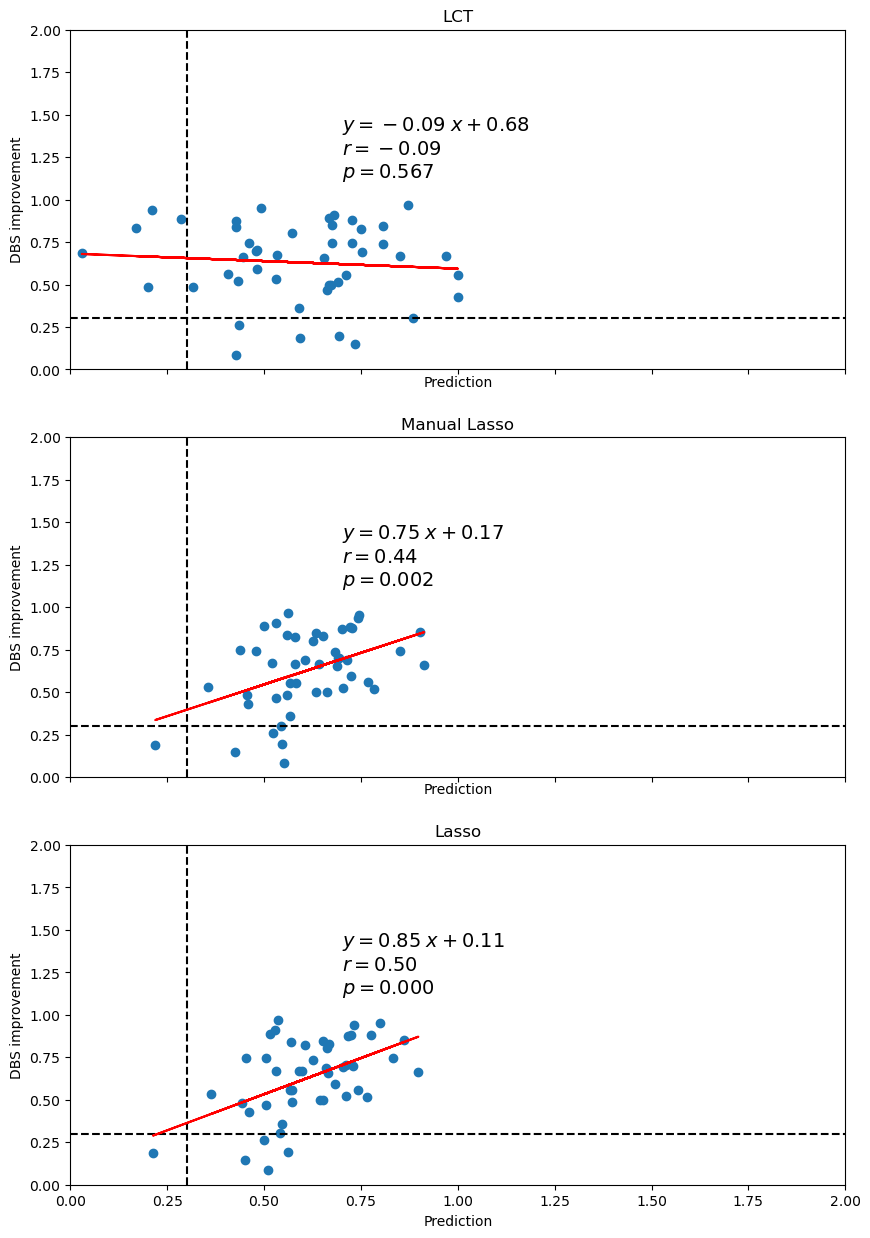

In [18]:
util.eval_prediction(np.vstack((pre_imp,
                               results_mls,
                               results_ls,
                            #    results_en[:np.sum(results_lr.ravel()!=0.)],
                            #    results_rr.ravel()[:np.sum(results_lr.ravel()!=0.)],
                            #    results_svr[:np.sum(results_lr.ravel()!=0.)],
                               )),
                               per_change,
                               ['LCT',
                                'Manual Lasso',
                                'Lasso',
                                # 'ElasticNet',
                                # 'Ridge',
                                # 'SVR',
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])